# Example 3: -  Including systematics

## Preparations

Let us first load all the python libraries again

In [3]:
import sys
import os
madminer_src_path = "/Users/dpappadopulo/Projects/~Physics/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge

from sklearn.metrics import mean_squared_error

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [4]:
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

To not forget anything later, let us globaly define the number of events in the MG sample

In [5]:
inputfile = 'data/madminer_lhedata_signal.h5'
nsamples = 800000

## 5. Data Analysis

### 5a) Setup Fisher Information

Let us first set up the Fisher Information class

In [6]:
fisher = FisherInformation(inputfile)

00:03 madminer.fisherinfor INFO    Loading data from data/madminer_lhedata_signal.h5
00:03 madminer.fisherinfor INFO    Found 2 parameters
00:03 madminer.fisherinfor INFO    Found 31 nuisance parameters
00:03 madminer.fisherinfor INFO    Found 81 benchmarks, of which 6 physical
00:03 madminer.fisherinfor INFO    Found 3 observables: mll, pt_mu, eta_mu
00:03 madminer.fisherinfor INFO    Found 900000 events
00:03 madminer.fisherinfor INFO    Found morphing setup with 6 components
00:03 madminer.fisherinfor INFO    Found nuisance morphing setup


### 5b) Evaluate Fisher Information - Full, Rate and Histograms

Let us first look at the Fisher Information in the full data, in the rate only and in a few kinematic distributions

In [7]:
"""
fi_full_mean, fi_full_cov = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,
    model_file='models/samples_ensemble',
    unweighted_x_sample_file='data/samples_ensemble/x_test.npy',
)

fi_rate_mean, fi_rate_cov = fisher.calculate_fisher_information_rate(
    theta=[0.,0.],luminosity=300*1000.
)

fi_dphi_mean, fi_dphi_cov = fisher.calculate_fisher_information_hist1d(
    theta=[0.,0.], luminosity=300*1000.,
    observable='dphi_mumu',nbins=20,histrange=(-3.2,3.2)
)
"""
fi_mll_mean, fi_mll_cov = fisher.calculate_fisher_information_hist1d(
    theta=[0.,0.], luminosity=300*1000.,
    observable='mll',nbins=20,histrange=(-3.2,3.2)
)

/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/madminer/fisherinformation.py:1351: RuntimeWarning: divide by zero encountered in true_divide
  inv_sigma = sanitize_array(1.0 / sigma)  # Shape (n_events,)
/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/madminer/morphing.py:695: RuntimeWarning: invalid value encountered in true_divide
  a.append(np.log(benchmark_weights[:, i_pos] / benchmark_weights[:, self.i_benchmark_ref]))


### 5c) No Systematics

To again obtain the Fisher Information without systematics, we can use `project_information()` to project out the nuisance parameter (set them all to zero).

In [11]:
"""
fi_full_mean_proj, fi_full_cov_proj = project_information(
    fisher_information=fi_full_mean, covariance=fi_full_cov,remaining_components=[0,1])
fi_rate_mean_proj, fi_rate_cov_proj = project_information(
    fisher_information=fi_rate_mean, covariance=fi_rate_cov,remaining_components=[0,1])
fi_dphi_mean_proj, fi_dphi_cov_proj = project_information(
    fisher_information=fi_dphi_mean, covariance=fi_dphi_cov,remaining_components=[0,1])
"""
fi_mll_mean_proj, fi_mll_cov_proj = project_information(
    fisher_information=fi_mll_mean, covariance=fi_mll_cov,remaining_components=[0,1])

Let's plot the result

/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/Users/dpappadopulo/miniconda3/envs/dpenv27/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


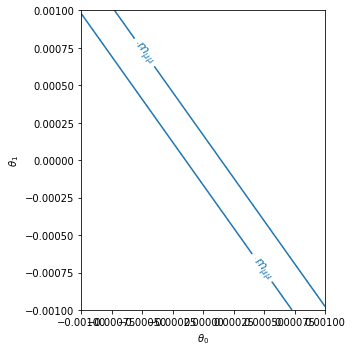

In [12]:
"""
_ = plot_fisher_information_contours_2d(
    [fi_full_mean_proj, fi_rate_mean_proj, fi_dphi_mean_proj],
    [fi_full_cov_proj , fi_rate_cov_proj , fi_dphi_cov_proj ],
    inline_labels=["Full","Rate","$\Delta\phi_{\mu\mu}$"],
    xrange=(-10,10),
    yrange=(-150,150)
)
"""
_ = plot_fisher_information_contours_2d(
    [fi_mll_mean_proj],
    [fi_mll_cov_proj ],
    inline_labels=["$m_{\mu\mu}$"],
    xrange=(-0.001,0.001),
    yrange=(-0.001,0.001)
)

### 5d) Including Systematics

We can also profile over the systematics. The nuisance parameters, by construction, follow Gaussian distributions with mean $\langle \nu \rangle=0 $ and width $\sigma_\nu=1$. This provides an additional contribution to the Fisher Information, $I_{ij}^{}=I_{ij}^{0}+I_{ij}^{\nu}$, where $I_{ij}$ is the total Fisher Info, $I^0_{ij}$ is the Fisher Information obtained by the analyzed process only and $I_{ij}^\nu = \delta_{ik}\delta_{kj}/{\sigma_\nu^2}$ is the addition contribution from the constraints of the nuisance parameter. Let's first calulate the Fisher Info for the nuisance parameter:

In [8]:
fi_nuisance = fisher.calculate_fisher_information_nuisance_constraints()

Now we can add the two Fisher Informations, and also profile over the nuisance parameters

In [13]:
"""
fi_full_mean_prof, fi_full_cov_prof = profile_information(
    fisher_information=fi_full_mean+fi_nuisance, covariance=fi_full_cov,remaining_components=[0,1])
fi_rate_mean_prof, fi_rate_cov_prof = profile_information(
    fisher_information=fi_rate_mean+fi_nuisance, covariance=fi_rate_cov,remaining_components=[0,1])
"""
fi_mll_mean_prof, fi_mll_cov_prof = profile_information(
    fisher_information=fi_mll_mean+fi_nuisance, covariance=fi_mll_cov,remaining_components=[0,1])

Let's now plot the result

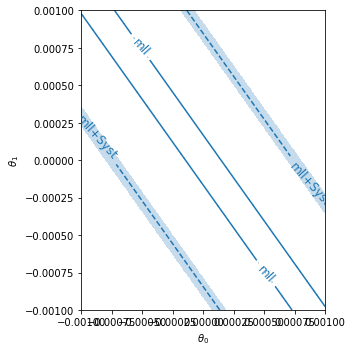

In [14]:
"""
_ = plot_fisher_information_contours_2d(
    [fi_full_mean_proj,fi_full_mean_prof,fi_rate_mean_proj,fi_rate_mean_prof,fi_dphi_mean_proj,fi_dphi_mean_prof],
    [fi_full_cov_proj ,fi_full_cov_prof ,fi_rate_cov_proj ,fi_rate_cov_prof ,fi_dphi_cov_proj ,fi_dphi_cov_prof ],
    inline_labels=["Full","Full+Syst","Rate","Rate+Syst","$\Delta\phi_{\mu\mu}$","$\Delta\phi_{\mu\mu}$+Syst"],
    linestyles=["solid","dashed","solid","dashed","solid","dashed"],
    colors=["C0","C0","C1","C1","C2","C2"],
    xrange=(-10,10),
    yrange=(-150,150),
)
"""

_ = plot_fisher_information_contours_2d(
    [fi_mll_mean_proj,fi_mll_mean_prof],
    [fi_mll_cov_proj ,fi_mll_cov_prof ],
    inline_labels=["mll","mll+Syst"],
    linestyles=["solid","dashed"],
    colors=["C0","C0"],
    xrange=(-0.001,0.001),
    yrange=(-0.001,0.001)
)